In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from catboost import CatBoostRegressor
import haversine as hs
from sklearn.impute import KNNImputer
import datetime as dt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
df=pd.read_csv("train.csv")
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min)
0,0x5725,CHENRES13DEL03,30.0,4.7,13.027018,80.254791,13.087018,80.314791,21-03-2022,23:40,23:45,Sunny,Low,2,Buffet,scooter,0.0,NaN,Urban,10.0
1,0x98ff,RANCHIRES05DEL02,23.0,4.1,23.355164,85.324097,23.375164,85.344097,28-03-2022,8:35,8:50,Stormy,Low,0,Drinks,motorcycle,0.0,No,Metropolitian,18.0
2,0x1bfb,COIMBRES19DEL02,23.0,4.7,11.022298,76.998349,11.072298,77.048349,01-04-2022,21:40,21:55,Fog,Jam,1,Meal,motorcycle,0.0,No,Metropolitian,29.0
3,0x86ea,COIMBRES19DEL02,23.0,4.6,11.022298,76.998349,11.152298,77.128349,20-03-2022,22:50,22:55,Fog,Low,0,Buffet,motorcycle,0.0,No,Urban,21.0
4,0xb04e,HYDRES19DEL01,25.0,5.0,17.458998,78.500366,17.468998,78.510366,03-03-2022,11:15,11:30,Cloudy,High,0,Snack,motorcycle,1.0,No,Urban,26.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          43739 non-null  float64
 3   Delivery_person_Ratings      43685 non-null  float64
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  43862 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weather                      44977 non-null  object 
 12  Road_traffic_density         44992 non-null  object 
 13  Vehicle_conditio

In [5]:
Missing = pd.DataFrame()
Missing['Sum'] = df.isna().sum()
Missing['Percentage'] = df.isna().mean() * 100
Missing= Missing[Missing['Sum'] > 0 ].sort_values(ascending=False,by='Sum')
Missing

,Sum,Percentage
Delivery_person_Ratings,1908,4.184853
Delivery_person_Age,1854,4.066414
Time_Orderd,1731,3.796635
City,1200,2.631983
multiple_deliveries,993,2.177966
Weather,616,1.351085
Road_traffic_density,601,1.318185
Festival,228,0.500077


* Time_Orderd is time imputing it is hard
* Insted of using the time of order Time_Orderd_picked - Time_Orderd => Time taken to pickup order
* we will convert the deliver time into minutes so 

In [6]:
df.drop('Time_Orderd',axis=1,inplace=True)

In [7]:
Missing = pd.DataFrame()
Missing['Sum'] = df.isna().sum()
Missing['Percentage'] = df.isna().mean() * 100
Missing= Missing[Missing['Sum'] > 0 ].sort_values(ascending=False,by='Sum')
Missing

,Sum,Percentage
Delivery_person_Ratings,1908,4.184853
Delivery_person_Age,1854,4.066414
City,1200,2.631983
multiple_deliveries,993,2.177966
Weather,616,1.351085
Road_traffic_density,601,1.318185
Festival,228,0.500077


In [8]:
# Knn_imputer numerical missing data
knn_imputer = KNNImputer()

In [9]:
df[['Delivery_person_Ratings','Delivery_person_Age','multiple_deliveries']] = knn_imputer.fit_transform(df[['Delivery_person_Ratings','Delivery_person_Age','multiple_deliveries']])

* we will dro`ID and Delivery_person_ID` 
* ID is an unique identifier so it doensn't help in 

In [10]:
Missing = pd.DataFrame()
Missing['Sum'] = df.isna().sum()
Missing['Percentage'] = df.isna().mean() * 100
Missing= Missing[Missing['Sum'] > 0 ].sort_values(ascending=False,by='Sum')
Missing


,Sum,Percentage
City,1200,2.631983
Weather,616,1.351085
Road_traffic_density,601,1.318185
Festival,228,0.500077


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='City', ylabel='count'>

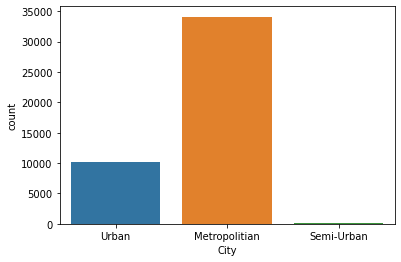

In [11]:
sns.countplot(df.City)

In [12]:
df.City.unique()

array(['Urban', 'Metropolitian', nan, 'Semi-Urban'], dtype=object)

* we will group semi urban an missing as one catagory as they are in very minor quantitties and name them others

In [13]:
df.City = df.City.apply(lambda x: 'other' if x not in ('Urban','Metropolitian') else x )

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='City', ylabel='count'>

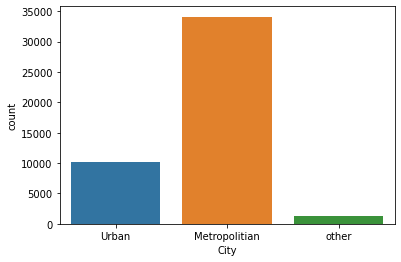

In [14]:
sns.countplot(df.City)

In [15]:
# rest 3 we will build knn imputation again but with lable encoding
missing_snapshot = df[['Weather','Road_traffic_density','Festival']].isna()
missing_snapshot.head()

,Weather,Road_traffic_density,Festival
0,False,False,True
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False


In [16]:
# this code convers missing snapshot to non missing snapshot mark
missing_snapshot = ~missing_snapshot
missing_snapshot.head()

,Weather,Road_traffic_density,Festival
0,True,True,False
1,True,True,True
2,True,True,True
3,True,True,True
4,True,True,True


In [17]:
df[['Weather','Road_traffic_density','Festival']].head()

,Weather,Road_traffic_density,Festival
0,Sunny,Low,NaN
1,Stormy,Low,No
2,Fog,Jam,No
3,Fog,Low,No
4,Cloudy,High,No


In [18]:
enc1= LabelEncoder()
df['Weather'] =enc.fit_transform(df['Weather'])

In [19]:
enc2= LabelEncoder()
df['Road_traffic_density'] =enc2.fit_transform(df['Road_traffic_density'])

In [20]:
enc3= LabelEncoder()
df['Festival'] =enc3.fit_transform(df['Festival'])

* with the use of lable enoder the missing values is also encoded to numerical value so we will eleiminate it with the help of snapshot table we built

In [21]:
df[['Weather','Road_traffic_density','Festival']].head()

,Weather,Road_traffic_density,Festival
0,4,2,2
1,3,2,0
2,1,1,0
3,1,2,0
4,0,0,0


In [22]:
df[['Weather','Road_traffic_density','Festival']] = df[['Weather','Road_traffic_density','Festival']][missing_snapshot]
df[['Weather','Road_traffic_density','Festival']].head()

,Weather,Road_traffic_density,Festival
0,4.0,2.0,NaN
1,3.0,2.0,0.0
2,1.0,1.0,0.0
3,1.0,2.0,0.0
4,0.0,0.0,0.0


* we successfully droped all null values encoded  duplicates
* now we will use KNN imputation to fill missing values

In [23]:
knn_cat = KNNImputer()

In [24]:
df[['Weather','Road_traffic_density','Festival']] = knn_cat.fit_transform(df[['Weather','Road_traffic_density','Festival']])

In [25]:
df[['Weather','Road_traffic_density','Festival']].head()

,Weather,Road_traffic_density,Festival
0,4.0,2.0,0.0
1,3.0,2.0,0.0
2,1.0,1.0,0.0
3,1.0,2.0,0.0
4,0.0,0.0,0.0


In [26]:
df[['Weather','Road_traffic_density','Festival']] = df[['Weather','Road_traffic_density','Festival']].astype(int)
df[['Weather','Road_traffic_density','Festival']] = df[['Weather','Road_traffic_density','Festival']].astype(object)

In [27]:
pd.set_option('display.max_columns',None)

In [28]:
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Order_picked,Weather,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min)
0,0x5725,CHENRES13DEL03,30.0,4.7,13.027018,80.254791,13.087018,80.314791,21-03-2022,23:45,4,2,2,Buffet,scooter,0.0,0,Urban,10.0
1,0x98ff,RANCHIRES05DEL02,23.0,4.1,23.355164,85.324097,23.375164,85.344097,28-03-2022,8:50,3,2,0,Drinks,motorcycle,0.0,0,Metropolitian,18.0
2,0x1bfb,COIMBRES19DEL02,23.0,4.7,11.022298,76.998349,11.072298,77.048349,01-04-2022,21:55,1,1,1,Meal,motorcycle,0.0,0,Metropolitian,29.0
3,0x86ea,COIMBRES19DEL02,23.0,4.6,11.022298,76.998349,11.152298,77.128349,20-03-2022,22:55,1,2,0,Buffet,motorcycle,0.0,0,Urban,21.0
4,0xb04e,HYDRES19DEL01,25.0,5.0,17.458998,78.500366,17.468998,78.510366,03-03-2022,11:30,0,0,0,Snack,motorcycle,1.0,0,Urban,26.0


* Delivery_person_ID too many features in it. using it increses dimensality

In [29]:
df.drop(['ID','Delivery_person_ID'],axis=1,inplace=True)

In [30]:
df[['Restaurant_latitude','Restaurant_longitude','Delivery_location_latitude','Delivery_location_longitude']].apply(lambda x: x[0], axis=1)

0        13.027018
1        23.355164
2        11.022298
3        11.022298
4        17.458998
           ...    
45588    17.428294
45589    12.986047
45590    13.086438
45591     0.000000
45592     0.000000
Length: 45593, dtype: float64

In [31]:
df['Distance']=df[['Restaurant_latitude','Restaurant_longitude','Delivery_location_latitude','Delivery_location_longitude']].apply(lambda x:hs.haversine((x[0],x[1]),(x[2],x[3])), axis=1)

In [32]:
df.drop(['Restaurant_latitude','Restaurant_longitude','Delivery_location_latitude','Delivery_location_longitude'],axis=1,inplace=True)

In [33]:
df.head()

,Delivery_person_Age,Delivery_person_Ratings,Order_Date,Time_Order_picked,Weather,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min),Distance
0,30.0,4.7,21-03-2022,23:45,4,2,2,Buffet,scooter,0.0,0,Urban,10.0,9.314043
1,23.0,4.1,28-03-2022,8:50,3,2,0,Drinks,motorcycle,0.0,0,Metropolitian,18.0,3.018873
2,23.0,4.7,01-04-2022,21:55,1,1,1,Meal,motorcycle,0.0,0,Metropolitian,29.0,7.790170
3,23.0,4.6,20-03-2022,22:55,1,2,0,Buffet,motorcycle,0.0,0,Urban,21.0,20.253082
4,25.0,5.0,03-03-2022,11:30,0,0,0,Snack,motorcycle,1.0,0,Urban,26.0,1.536721


In [34]:
df.Order_Date = df.Order_Date.astype('datetime64[ns]')

In [35]:
df['Month'] = df.Order_Date.dt.month

In [36]:
df.drop('Order_Date',axis=1,inplace=True)

In [37]:
df['Month']= df['Month'].astype('object')

In [38]:
df.head()

,Delivery_person_Age,Delivery_person_Ratings,Time_Order_picked,Weather,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min),Distance,Month
0,30.0,4.7,23:45,4,2,2,Buffet,scooter,0.0,0,Urban,10.0,9.314043,3
1,23.0,4.1,8:50,3,2,0,Drinks,motorcycle,0.0,0,Metropolitian,18.0,3.018873,3
2,23.0,4.7,21:55,1,1,1,Meal,motorcycle,0.0,0,Metropolitian,29.0,7.790170,1
3,23.0,4.6,22:55,1,2,0,Buffet,motorcycle,0.0,0,Urban,21.0,20.253082,3
4,25.0,5.0,11:30,0,0,0,Snack,motorcycle,1.0,0,Urban,26.0,1.536721,3


In [39]:
df.Time_Order_picked = df.Time_Order_picked.apply(lambda x: 'Morning' if (int(x.split(':')[0]) < 12 and int(x.split(':')[0]) >8) else( 'Afternoon' if int(x.split(':')[0])<16 else( 'Evening' if int(x.split(':')[0]) < 19 else 'Night')))

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Time_Order_picked', ylabel='count'>

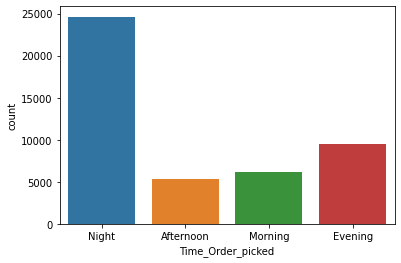

In [40]:
sns.countplot(df.Time_Order_picked )

In [41]:
df.head()

,Delivery_person_Age,Delivery_person_Ratings,Time_Order_picked,Weather,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min),Distance,Month
0,30.0,4.7,Night,4,2,2,Buffet,scooter,0.0,0,Urban,10.0,9.314043,3
1,23.0,4.1,Afternoon,3,2,0,Drinks,motorcycle,0.0,0,Metropolitian,18.0,3.018873,3
2,23.0,4.7,Night,1,1,1,Meal,motorcycle,0.0,0,Metropolitian,29.0,7.790170,1
3,23.0,4.6,Night,1,2,0,Buffet,motorcycle,0.0,0,Urban,21.0,20.253082,3
4,25.0,5.0,Morning,0,0,0,Snack,motorcycle,1.0,0,Urban,26.0,1.536721,3


In [42]:
df.multiple_deliveries = df.multiple_deliveries.astype(int)
df.multiple_deliveries = df.multiple_deliveries.astype('category')

In [43]:
unique_col =[]
bool_col = []
cat_col = []
cont_col =[]

In [44]:
for i in df.drop('Time_taken (min)',axis=1).columns:
    unique_count = df[i].nunique()
    if ( unique_count ==1):
        unique_col.append(i)
    elif( unique_count ==2 ):
        bool_col.append(i)
    elif unique_count < 25:
        cat_col.append(i)
    else :
        cont_col.append(i)

In [45]:
print("Unique columns in data are",unique_col,end='\n \n')
print("Boolean columns in data are",bool_col,end='\n \n')
print("Catagorical columns in data are",cat_col,end='\n \n')
print("Continuious columns in data are",cont_col,end='\n \n')

Unique columns in data are []
 
Boolean columns in data are ['Festival']
 
Catagorical columns in data are ['Time_Order_picked', 'Weather', 'Road_traffic_density', 'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle', 'multiple_deliveries', 'City', 'Month']
 
Continuious columns in data are ['Delivery_person_Age', 'Delivery_person_Ratings', 'Distance']
 


In [46]:
df[cat_col].head()

,Time_Order_picked,Weather,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,City,Month
0,Night,4,2,2,Buffet,scooter,0,Urban,3
1,Afternoon,3,2,0,Drinks,motorcycle,0,Metropolitian,3
2,Night,1,1,1,Meal,motorcycle,0,Metropolitian,1
3,Night,1,2,0,Buffet,motorcycle,0,Urban,3
4,Morning,0,0,0,Snack,motorcycle,1,Urban,3


In [47]:
df[cat_col] = df[cat_col].astype('category')

# Hyper parameter tuning

In [48]:
def objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(df.drop('Time_taken (min)',axis=1),df['Time_taken (min)'],test_size=0.15,random_state=42)
    
    param = {
        'eval_metric': 'RMSE', 
        'n_estimators': trial.suggest_int('n_estimators',500,9000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001,0.2 ),
        'depth' : trial.suggest_int('depth', 9, 15),
        'l2_leaf_reg' : trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'random_strength' : trial.suggest_float('random_strength',0.2,0.8),
        'bagging_temperature':trial.suggest_loguniform('bagging_temperature',0.03,0.8),
        'border_count': 254,
        'cat_features':cat_col,
        'od_type' : 'Iter',
        'use_best_model': True,
        'task_type' : 'GPU',
        'random_state' : 42,
        'logging_level' : 'Silent'
    }
                                                        
    model = CatBoostRegressor(**param)  
    model.set_params(early_stopping_rounds=100)
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],verbose=1000)
    
    preds = model.predict(test_x)
    
    mse = mean_squared_error(test_y, preds,squared=True)
    
    return mse

In [49]:
study = optuna.create_study(direction='minimize')
study.optimize(objective,show_progress_bar=True,timeout=7200)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-09-04 09:39:17,743] A new study created in memory with name: no-name-c8c5bc0a-7e65-4dc5-bd8b-8c7f64c44fc0
/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


0it [00:00, ?it/s]

[I 2022-09-04 09:43:47,834] Trial 0 finished with value: 14.6996025311846 and parameters: {'n_estimators': 4443, 'learning_rate': 0.08211344222111697, 'depth': 10, 'l2_leaf_reg': 0.03989497847443306, 'random_strength': 0.7256397053081882, 'bagging_temperature': 0.5051084021636925}. Best is trial 0 with value: 14.6996025311846.
[I 2022-09-04 09:55:16,812] Trial 1 finished with value: 14.696923572549112 and parameters: {'n_estimators': 6855, 'learning_rate': 0.07089255025379998, 'depth': 15, 'l2_leaf_reg': 0.006804572878344884, 'random_strength': 0.7501544940035574, 'bagging_temperature': 0.7552965718084396}. Best is trial 1 with value: 14.696923572549112.
[I 2022-09-04 10:03:40,936] Trial 2 finished with value: 14.664474150557135 and parameters: {'n_estimators': 4129, 'learning_rate': 0.03303037192812596, 'depth': 14, 'l2_leaf_reg': 0.23308914959188204, 'random_strength': 0.5809142341719788, 'bagging_temperature': 0.10870445013006544}. Best is trial 2 with value: 14.664474150557135.
[I 

In [51]:
params = {'n_estimators': 5600, 'learning_rate': 0.04144747481231018, 'depth': 15, 'l2_leaf_reg': 2.8862273654780424, 'random_strength': 0.4039222562811846, 'bagging_temperature': 0.03152895581074059}

In [53]:
model = CatBoostRegressor(**params,border_count=254,cat_features=cat_col,od_type='Iter',task_type='GPU',random_state=42,logging_level= 'Silent')

In [54]:
model.fit(df.drop('Time_taken (min)',axis=1),df['Time_taken (min)'])

# Test Dataset

In [57]:
test= pd.read_csv('test.csv')
test.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City
0,0x3a80,BANGRES15DEL02,32.0,4.9,12.975377,77.696664,13.055377,77.776664,20-03-2022,23:25,23:40,Sandstorms,Low,2,Drinks,scooter,1.0,No,Metropolitian
1,0x4e2d,INDORES01DEL01,32.0,4.8,22.695207,75.866059,22.735207,75.906059,26-03-2022,14:40,14:55,Windy,High,1,Meal,scooter,1.0,No,Urban
2,0x4ba7,COIMBRES17DEL01,39.0,3.6,11.026117,76.944652,11.096117,77.014652,02-03-2022,20:55,21:05,Sunny,Jam,2,Meal,motorcycle,1.0,No,Metropolitian
3,0x1f09,CHENRES010DEL01,33.0,4.1,13.066762,80.251865,13.136762,80.321865,20-03-2022,18:20,18:30,Sunny,Medium,0,Drinks,motorcycle,2.0,No,Metropolitian
4,0x547,MYSRES11DEL03,NaN,NaN,-12.323225,76.630028,12.383225,76.690028,05-03-2022,NaN,22:15,NaN,NaN,0,Meal,motorcycle,1.0,No,Metropolitian


In [60]:
test[['Delivery_person_Ratings','Delivery_person_Age','multiple_deliveries']] = knn_imputer.transform(test[['Delivery_person_Ratings','Delivery_person_Age','multiple_deliveries']])

In [61]:
Missing = pd.DataFrame()
Missing['Sum'] = test.isna().sum()
Missing['Percentage'] = test.isna().mean() * 100
Missing= Missing[Missing['Sum'] > 0 ].sort_values(ascending=False,by='Sum')
Missing

,Sum,Percentage
Time_Orderd,444,3.895079
City,324,2.842355
Weather,158,1.386086
Road_traffic_density,154,1.350996
Festival,65,0.570225


In [62]:
test.City = test.City.apply(lambda x: 'other' if x not in ('Urban','Metropolitian') else x )

In [63]:
# taking snapshot bakup of what are non missing values
missing_snapshot = test[['Weather','Road_traffic_density','Festival']].isna()
missing_snapshot = ~missing_snapshot
missing_snapshot.head()

,Weather,Road_traffic_density,Festival
0,True,True,True
1,True,True,True
2,True,True,True
3,True,True,True
4,False,False,True


In [69]:
test['Weather'] =enc1.transform(test['Weather'])
test['Road_traffic_density'] =enc2.transform(test['Road_traffic_density'])
test['Festival'] =enc3.transform(test['Festival'])

In [70]:
test[['Weather','Road_traffic_density','Festival']] = test[['Weather','Road_traffic_density','Festival']][missing_snapshot]
test[['Weather','Road_traffic_density','Festival']].head()

,Weather,Road_traffic_density,Festival
0,2.0,2.0,0.0
1,5.0,0.0,0.0
2,4.0,1.0,0.0
3,4.0,3.0,0.0
4,NaN,NaN,0.0


In [71]:
test[['Weather','Road_traffic_density','Festival']] = knn_cat.transform(test[['Weather','Road_traffic_density','Festival']])

In [72]:
test[['Weather','Road_traffic_density','Festival']] = test[['Weather','Road_traffic_density','Festival']].astype(int)
test[['Weather','Road_traffic_density','Festival']] = test[['Weather','Road_traffic_density','Festival']].astype(object)

In [73]:
test['Distance']=test[['Restaurant_latitude','Restaurant_longitude','Delivery_location_latitude','Delivery_location_longitude']].apply(lambda x:hs.haversine((x[0],x[1]),(x[2],x[3])), axis=1)
test.drop(['Restaurant_latitude','Restaurant_longitude','Delivery_location_latitude','Delivery_location_longitude'],axis=1,inplace=True)

In [74]:
test.Order_Date = test.Order_Date.astype('datetime64[ns]')
test['Month'] = test.Order_Date.dt.month
test.drop('Order_Date',axis=1,inplace=True)
test['Month']= test['Month'].astype('object')

In [75]:
test.Time_Order_picked = test.Time_Order_picked.apply(lambda x: 'Morning' if (int(x.split(':')[0]) < 12 and int(x.split(':')[0]) >8) else( 'Afternoon' if int(x.split(':')[0])<16 else( 'Evening' if int(x.split(':')[0]) < 19 else 'Night')))

In [76]:
test.multiple_deliveries = test.multiple_deliveries.astype(int)
test.multiple_deliveries = test.multiple_deliveries.astype('category')

In [77]:
test[cat_col] = test[cat_col].astype('category')

In [ ]:
test.drop([''])

In [78]:
test.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Time_Orderd,Time_Order_picked,Weather,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Distance,Month
0,0x3a80,BANGRES15DEL02,32.0,4.9,23:25,Night,2,2,2,Drinks,scooter,1,0,Metropolitian,12.419742,3
1,0x4e2d,INDORES01DEL01,32.0,4.8,14:40,Afternoon,5,0,1,Meal,scooter,1,0,Urban,6.051117,3
2,0x4ba7,COIMBRES17DEL01,39.0,3.6,20:55,Night,4,1,2,Meal,motorcycle,1,0,Metropolitian,10.905985,2
3,0x1f09,CHENRES010DEL01,33.0,4.1,18:20,Evening,4,3,0,Drinks,motorcycle,2,0,Metropolitian,10.865424,3
4,0x547,MYSRES11DEL03,30.0,4.6,NaN,Night,3,2,0,Meal,motorcycle,1,0,Metropolitian,2747.243665,5


In [83]:
test.drop(["Delivery_person_ID","Time_Orderd"],axis=1,inplace=True)

# Model Prediction

In [82]:
submission = pd.DataFrame()
submission['ID'] = test.ID 

In [87]:
submission["Time_taken (min)"] = np.round(model.predict(test.drop("ID",axis=1)),1)

In [88]:
submission.head()

,ID,Time_taken (min)
0,0x3a80,22.4
1,0x4e2d,28.4
2,0x4ba7,32.5
3,0x1f09,37.3
4,0x547,24.5


In [90]:
submission.to_csv("submission02_catboost.csv",index=False)